In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from data.torch_data_loaders import homography_dataset
from board_detection.homomography_network import HomographyNet
from board_detection.homomography_training import show_perspective_corrected_board
from board_detection.homomography_training import load_dataset
from board_detection.homomography_training import train_model
from board_detection.homomography_training import calculate_test_loss
from board_detection.homography_loss import PhotometricLoss

In [2]:
input_transform_pipeline = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor()
])

label_transform_pipeline = transforms.Compose([
    homography_dataset.HomographyOutputTransform((512, 512), (128, 128)),
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)), 
    transforms.Lambda(lambda x: torch.flatten(x))
])

json_path = 'data/full/perspective_distorted_boards/bbox_coordinates.json'
img_dir = "data/full/perspective_distorted_boards"

dataset = load_dataset(json_path, img_dir, input_transform_pipeline, label_transform_pipeline)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size


train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

learning_rate = 0.001
num_epochs = 52
model = HomographyNet(9) #9 cuz the matrix is flat 3 x 3
# criterion = nn.MSELoss()
criterion = PhotometricLoss()
device = "cpu"
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
save_path = "runs/models/homomography_hybrid_model.pth"
# save_path = None
resume_path = "runs/models/homomography_model.pth"
# resume_path = None


train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs, device, save_path, resume_path)
test_loss = calculate_test_loss(model, test_loader, criterion, device)

Resuming training from epoch 50


100%|██████████| 125/125 [06:46<00:00,  3.25s/it]


Epoch [50/52], Loss: 0.0131
Model saved to runs/models/homomography_hybrid_model.pth


100%|██████████| 125/125 [06:52<00:00,  3.30s/it]


Epoch [51/52], Loss: 0.0111
Model saved to runs/models/homomography_hybrid_model.pth


100%|██████████| 125/125 [07:16<00:00,  3.49s/it]


Epoch [52/52], Loss: 0.0090
Model saved to runs/models/homomography_hybrid_model.pth


100%|██████████| 125/125 [02:52<00:00,  1.38s/it]


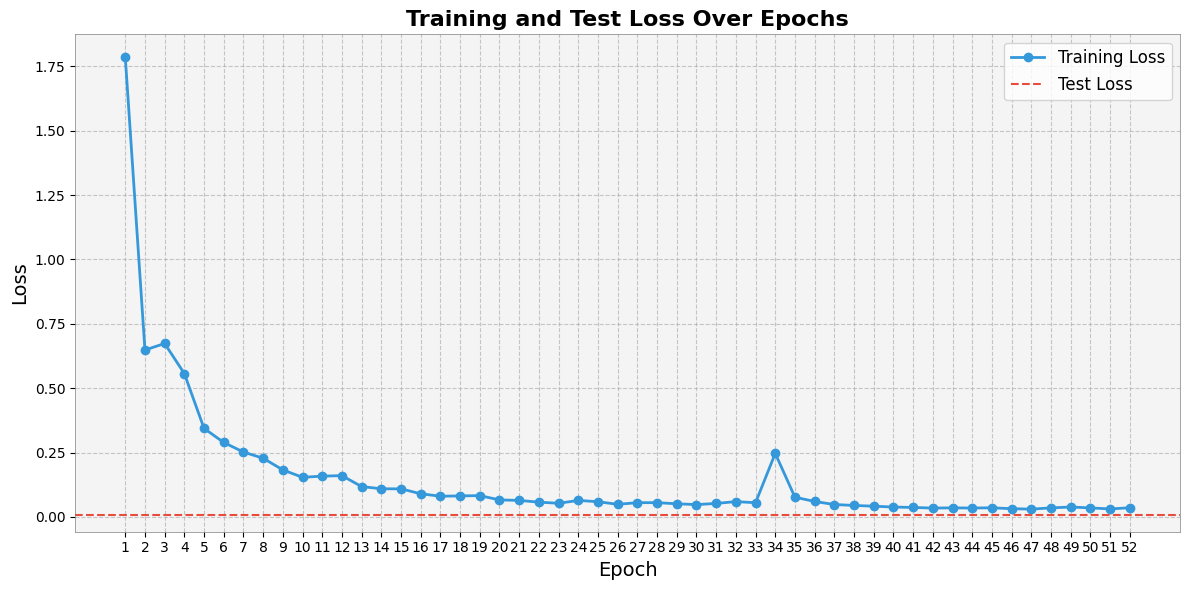

In [4]:
from visualization import show_loss 
show_loss.show_train_test_loss(train_losses[:52], test_loss, num_epochs)

[[ 1.2391740e+00  1.2602347e-01 -1.4661483e+01]
 [-1.3563335e-01  1.1699119e+00 -2.1895492e+00]
 [-8.9285906e-10 -6.7794581e-10  1.0000000e+00]]
[[ 27.871874   -19.381807    -0.73335207]
 [-34.40476     23.45011    -32.397717  ]
 [-18.7435     -22.762188    30.751976  ]]


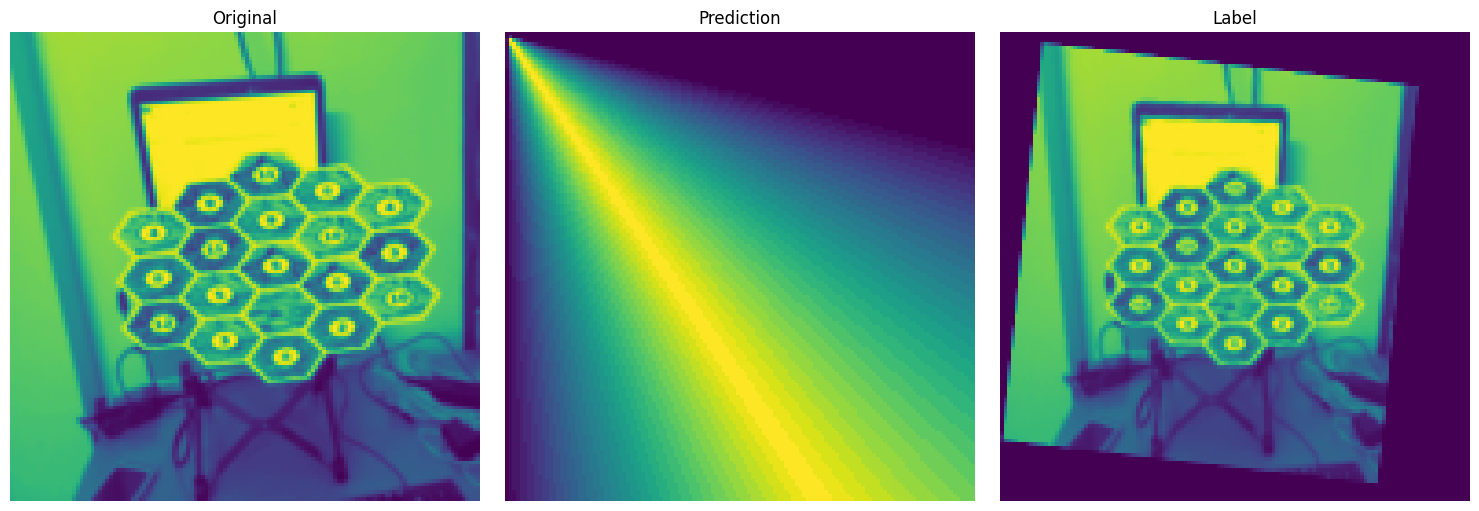

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.11397059, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03688726, 0.6105392 , 0.40130976, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.01901808, 0.01902191, ..., 0.4779412 , 0.4779412 ,
        0.47794122],
       [0.        , 0.01901808, 0.01902191, ..., 0.4779412 , 0.4779412 ,
        0.4779412 ],
       [0.        , 0.01901808, 0.01902191, ..., 0.4779412 , 0.4779412 ,
        0.4779412 ]], dtype=float32)

In [6]:
image, label = dataset.__getitem__(np.random.randint(0, dataset.__len__()))

matrix = model(image.unsqueeze(0))

# label, matrix = label.detach().numpy().reshape(3, 3), 
print(label.detach().numpy().reshape(3, 3))
print(matrix.detach().numpy().reshape(3, 3))
show_perspective_corrected_board(model, image, label)

In [ ]:
from ultralytics import YOLO
from board_detection.yolo_extraction import board_detection_step


data_dir = "data/sample/perspective_distorted_boards_sample/images"
model_path = "runs/detect/train10/weights/best.pt"  # Replace with your trained model
class_id_to_find = 0  # Change this to the class ID of the object you want to search for

model = YOLO(model_path)
# Run detection & plot results
board_detection_step("data/full/perspective_distorted_boards/train/images/canvas_image_0.png", model)

NameError: name 'class_id_to_find' is not defined